# Implementation of Natural Policy Gradients with SoftMax Parameterization


#### *pymdptoolbox* is a python library from which MDP examples can be imported </br>
##### Documentation of *pymdptoolbox* : https://pymdptoolbox.readthedocs.io/en/latest/api/mdptoolbox.html

In [ ]:
!pip install pymdptoolbox   #Install pymdptoolbox within the code

In [1]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

## Class MarkovDP 



In [2]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards = np.random.rand(self.num_action,self.num_state,self.num_state)

## Policy Iteration to find optimal

In [3]:
# Policy Evaluation Function
def evaluate_policy(env, pi, gamma, theta):
    V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

# Function that chooses the greedy action for a particular state 's'
def choose_best_action(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    action=np.argmax(q)        #Choose greedy action
    pi[s][action]=1            #Update Policy


#Policy Improvement step
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        choose_best_action(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

#Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
    return V, pi

## Evaluate Q under policy $\pi$<sub>t</sub>

In [4]:
def evaluate_q(env, pi, gamma, V):
    Q = np.zeros((env.num_state,env.num_action))
    for s in env.states:
      for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        Q[s][a] = np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    return Q

## Policy Update
$\pi$<sub>t+1</sub>(a|s) = $\pi$<sub>t</sub>(a|s)  exp(η A<sup>t</sup>(s, a) / (1−γ)) Z<sup>t</sup>(s)</br>where, </br> Z<sup>t</sup>(s) =∑<sub>a∈A</sub> $\pi$<sub>t</sub>(a|s) exp(η A<sup>t</sup>(s, a)/(1−γ))

## Constant step size

In [5]:
def softmax_npg(env,gamma,theta,rho,iterations,V_rho_optimal,step_size):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action
    history=list()  #Save value functions to observe convergence 
    learning_rate = 1
    for i in range(0,iterations):
        V = evaluate_policy(env, pi, gamma, theta) #Compute value functions V(s) under current policy
        Q = evaluate_q(env, pi, gamma, V)           #Compute Q-values Q(s,a) under current policy
        A = Q-V      #Compute advantage A(s,a)
        X=np.empty((env.num_state,env.num_action),dtype=float)
        for s in env.states:
          for a in env.actions:
            X[s][a]= np.exp(step_size*A[s][a]/(1-gamma))
          X[s]=X[s]/np.sum(np.multiply(X[s],pi[s]))
        ''' Policy update  '''
        pi=np.multiply(pi,X)    
        t=(V_rho_optimal-np.dot(rho,V)[0])
        history.append(t)
    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))
    return pi,V,history
 

## Plot log(V<sup>*</sup> - V<sup>t</sup>) vs log(t)

In [6]:
def plot_log(history,iterations):
    
    x=np.log(np.array(range(0,iterations)))
    y=np.log(np.array(history)[:])
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('log(t)', fontsize=12)
    plt.ylabel('log(V_opt-V(t))', fontsize=12)
    plt.plot(x,y,color='blue', label='SoftMax NPG') 
    #plt.title(title,fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

## Example 1

In [7]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=4
a=2
env1= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env1.initialize_mdp()    #Define P and R

In [8]:
gamma = 0.9       #Discount rate
theta = 0.0001    #A small positive number
rho= np.ones(env1.num_state)/env1.num_state

start_time = time.time()
V_optimal_policy,pi_optimal_policy = policy_iteration(env1, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.037432193756103516 seconds ---


In [9]:
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

In [10]:
V_rho_optimal

6.953538391841189

In [11]:
pi_optimal_policy

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [12]:
iterations = 120
step_size = 0.1
pi_npg,V_npg,history_npg = softmax_npg(env1,gamma,theta,rho,iterations,V_rho_optimal,step_size)

Iterations Completed
--- 2.063502073287964 seconds ---


In [13]:
pi_npg

array([[1.24859273e-25, 1.00000000e+00],
       [9.99999999e-01, 1.23829580e-09],
       [1.99329419e-06, 9.99998007e-01],
       [1.00000000e+00, 4.93717320e-19]])

In [14]:
V_npg

array([[7.25170073],
       [6.74961229],
       [6.78834311],
       [7.02449711]])

In [15]:
V_optimal_policy

array([[7.25170073],
       [6.74961229],
       [6.7883434 ],
       [7.02449714]])

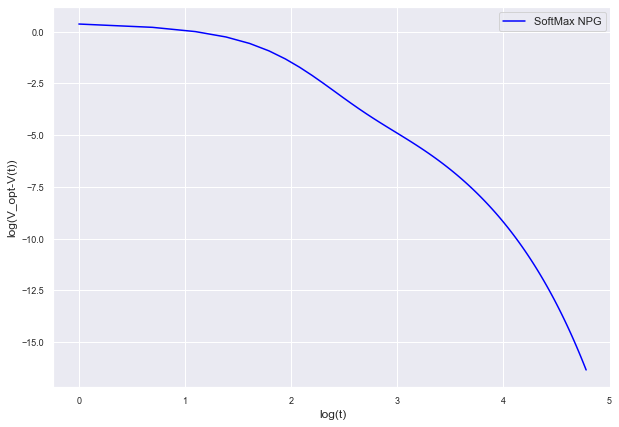

In [17]:
plot_log(history_npg,iterations)

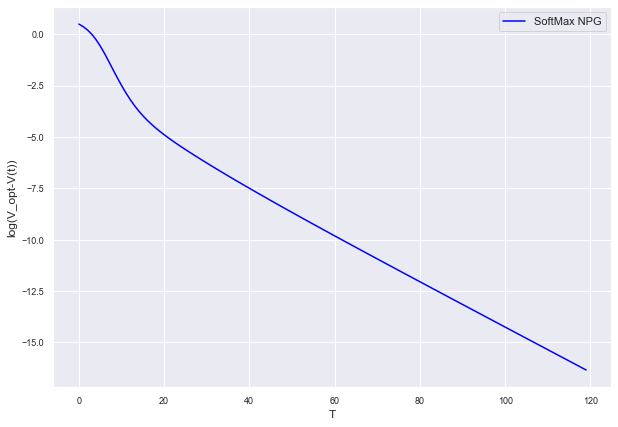

In [18]:
def plot_antilog(history,iterations):
    
    x=np.array(range(0,iterations))
    #x=np.log(np.array(range(0,iterations)))
    y=np.log(np.array(history)[:])
    slope,intercept= np.polyfit(x[2:14],y[2:14],deg=1) 
    label='Slope = '+ str(np.round(slope,3))
    abline_values = [slope * i + intercept for i in x]
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('T', fontsize=12)
    plt.ylabel('log(V_opt-V(t))', fontsize=12)
    #plt.plot(x,abline_values,'r--',label=label,linewidth=2)
    plt.plot(x,y,color='blue', label='SoftMax NPG') 
    #plt.title(title,fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()
plot_antilog(history_npg,iterations)

## Example 2

In [19]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=100
a=2
env2= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env2.initialize_mdp()    #Define P and R

In [20]:
gamma = 0.9       #Discount rate
theta = 0.0001    #A small positive number
rho= np.ones(env2.num_state)/env2.num_state

''' Policy Iteration to find optimal '''

start_time = time.time()
V_optimal_policy,pi_optimal_policy = policy_iteration(env2, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7861850261688232 seconds ---


In [21]:
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

In [22]:
V_rho_optimal

5.385333280639947

In [23]:
iterations = 200
step_size = 0.1
pi_npg,V_npg,history_npg = softmax_npg(env2,gamma,theta,rho,iterations,V_rho_optimal,step_size)

Iterations Completed
--- 40.3275101184845 seconds ---


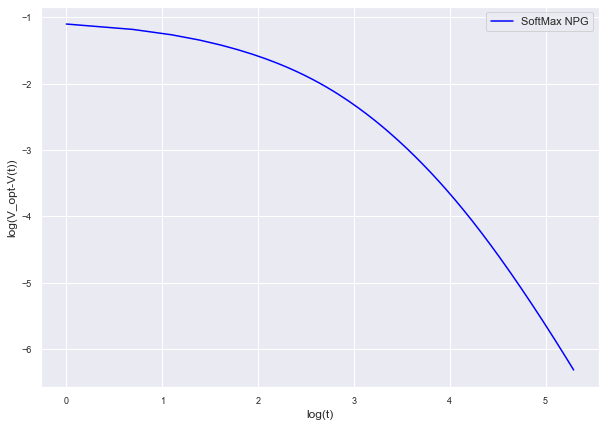

In [24]:
plot_log(history_npg,iterations)

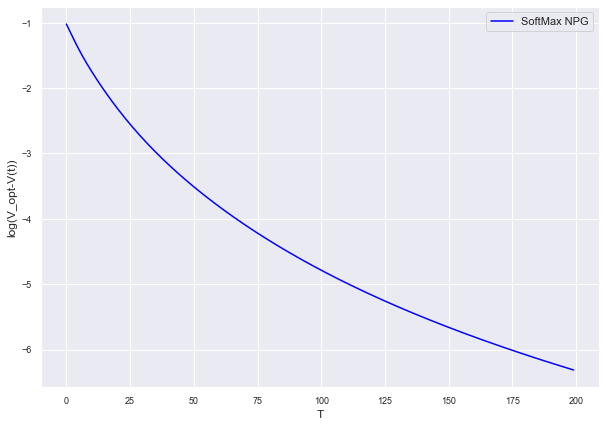

In [25]:
def plot_antilog(history,iterations):
    
    x=np.array(range(0,iterations))
    #x=np.log(np.array(range(0,iterations)))
    y=np.log(np.array(history)[:])
    slope,intercept= np.polyfit(x[2:54],y[2:54],deg=1) 
    label='Slope = '+ str(np.round(slope,3))
    abline_values = [slope * i + intercept for i in x]
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('T', fontsize=12)
    plt.ylabel('log(V_opt-V(t))', fontsize=12)
    #plt.plot(x,abline_values,'r--',label=label,linewidth=2)
    plt.plot(x,y,color='blue', label='SoftMax NPG') 
    #plt.title(title,fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()
plot_antilog(history_npg,iterations)

In [26]:
V_rho_npg = np.dot(rho,V_npg)[0]

In [27]:
V_rho_npg

5.383520885224556